In [8]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

from lettuce.flows.TGV3Dred import SuperReducedTaylorGreenVortex3D as TGV3Dred
from lettuce.simulation_TGV import SimulationReducedTGV
from lettuce.observables_TGV3Dred import *
from lettuce.simulation_TGV import *

In [9]:
"""Hier die ganzen Parser Argumente für die Simulation im Cluster"""

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=16)
parser.add_argument("--nout", type=int, default=100, help="Anzahl der gesamten n Observablenmesssungen")
parser.add_argument("--nvtk", type=int, default=200, help="Anzahl der gesamten n VTK-Outputs")
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
args, unknown = parser.parse_known_args()
args = vars(args)

Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
collision_operator = args["collision_operator"]



ICH FUNKTIONIERE MIT PULLEN


In [10]:
"""Aufbau der Simulation, da kannst du noch deinen Kollisionsoperatpor reinschmeissen udn das damit laufen lassen"""

lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float64)
flow = TGV3Dred(resolution=res, reynolds_number=Re, mach_number=0.05, lattice=lattice)

function_name = f"{collision_operator}Collision"

if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
"""elif collision_operator == "NCO"
    collision=lt.NeuralCollisionOperator(...)"""

streaming = lt.StandardStreaming(lattice)
simulation = SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


3528.504930699469


In [11]:
"""Output der Observablen und VTK Dateien"""

interval_vtk=int((flow.units.convert_time_to_lu(tmax))/nvtk)
interval_out=int((flow.units.convert_time_to_lu(tmax))/nout)


Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=Dissipation_TGV(lattice, flow)


reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2= lt.ObservableReporter(Dissipation_TGV, interval=interval_out, out=None)


simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_TGV


In [12]:
"""Initialisierung fneq und Simulationsdauer """

simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)

In [13]:
"""Alle Observablen umgerechnet auf den originalen TGV"""

energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])

"""Diss = - dEkin/dt mithilfe Differenzenquotient 6. Ordnung mit Randwerten 4., 2., 1. Ordnung"""

for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt

dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*0.5)**3])


"""Umrechnung, Dippation_TGV (2) ist die Ensttrophy und (3) über Sij, daher muss (2) noch genormt werden, (3) ist soweit schon korrekt"""
dissipationEns=np.array([dissipation[:,1],1/(0.5*np.pi)**3*dissipation[:,3]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

"""Abspeichern der Daten, kann man oben angeben, wo alles landen soll"""

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)

505 0.01983843054631176


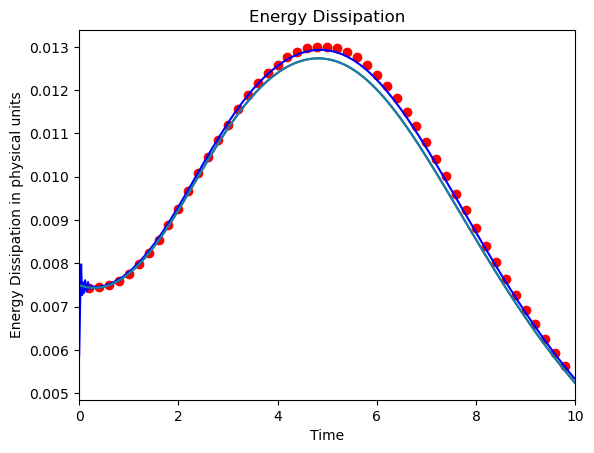

In [14]:
"""Beispielplot, der hier erstellt wird. Für dich zum erstmaligen testen sinnvoll, danach ab in den Müll, die Dissipationswerte werden ja sowieso abgespeichert"""


csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)

plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()